# Trend Comparison

This notebook analyzes similarity in trends between pairs of topics.

In [1]:
import sys
import os
import pyspark
import math
from operator import add

## Load Dataset

In [2]:
import preproc as pre

dataRDD = sc.parallelize(pre.get_list())

for line in dataRDD.take(10):
    print 'Topic: {}. Tag: {},{}. Year: {}. Page count: {}. Volume count: {}'.format(
        line[0], line[1][0], line[1][1], line[2], line[3], line[4])

Topic: amber alert. Tag: n,n. Year: 1987. Page count: 1. Volume count: 1
Topic: amber alert. Tag: n,n. Year: 1990. Page count: 1. Volume count: 1
Topic: amber alert. Tag: n,n. Year: 1999. Page count: 1. Volume count: 1
Topic: amber alert. Tag: n,n. Year: 2001. Page count: 1. Volume count: 1
Topic: amber alert. Tag: n,n. Year: 2003. Page count: 2. Volume count: 2
Topic: amber alert. Tag: n,n. Year: 2005. Page count: 16. Volume count: 12
Topic: amber alert. Tag: n,n. Year: 2006. Page count: 14. Volume count: 13
Topic: amber alert. Tag: n,n. Year: 2007. Page count: 12. Volume count: 10
Topic: amber alert. Tag: n,n. Year: 2008. Page count: 11. Volume count: 11
Topic: amber alert. Tag: n,n. Year: 1987. Page count: 1. Volume count: 1


## Volume Frequency over Years

In [3]:
def volume_freq(dataRDD):
    topic_yr_to_nvol = (dataRDD
                        .map(lambda x: ((x[0], x[2]), x[4]))
                        .reduceByKey(add)
                       )
    return topic_yr_to_nvol

volFreqRDD = volume_freq(dataRDD)
print volFreqRDD.take(5)

[((u'amplitude modulation', 1996), 5813), ((u'distributed system', 1918), 1892), ((u'information theory', 1930), 8), ((u'college education', 1826), 20), ((u'nuclear weapon', 1994), 33881)]


In [4]:
def merge_dict(a, b):
    for k in b:
        a[k] = b[k]
    return a

def volume_freq_trend(dataRDD):
    topic_to_yr_vol = (dataRDD
                       .map(lambda x: (x[0][0], {x[0][1]: x[1]}))
                       .reduceByKey(merge_dict)                       
                      )
    return topic_to_yr_vol

volTrendRDD = volume_freq_trend(volFreqRDD)
print volTrendRDD.take(3)

[(u'communist party', {1777: 4, 1817: 4, 1827: 4, 1838: 6, 1839: 8, 1846: 4, 1848: 4, 1849: 12, 1851: 8, 1854: 28, 1863: 12, 1865: 4, 1868: 4, 1869: 4, 1870: 38, 1871: 32, 1872: 24, 1873: 8, 1874: 8, 1875: 28, 1876: 12, 1877: 32, 1878: 32, 1879: 32, 1880: 40, 1881: 44, 1882: 8, 1883: 56, 1884: 48, 1885: 28, 1886: 8, 1887: 16, 1888: 12, 1889: 4, 1890: 24, 1891: 100, 1892: 72, 1893: 70, 1894: 96, 1895: 32, 1896: 36, 1897: 12, 1898: 52, 1899: 76, 1900: 78, 1901: 90, 1902: 56, 1903: 60, 1904: 76, 1905: 46, 1906: 128, 1907: 104, 1908: 78, 1909: 100, 1910: 48, 1911: 96, 1912: 64, 1913: 56, 1914: 90, 1915: 62, 1916: 58, 1917: 96, 1918: 266, 1919: 482, 1920: 1288, 1921: 1431, 1922: 1388, 1923: 1061, 1924: 1198, 1925: 1035, 1926: 1204, 1927: 1630, 1928: 1787, 1929: 1798, 1930: 1943, 1931: 2745, 1932: 2839, 1933: 2753, 1934: 4107, 1935: 4303, 1936: 3928, 1937: 5004, 1938: 5271, 1939: 5349, 1940: 5106, 1941: 4452, 1942: 4380, 1943: 4694, 1944: 4476, 1945: 5020, 1946: 6183, 1947: 7755, 1948: 7726,

## Similarity in Volume Frequency between Topic Pairs

#### Compute Dissimilarity or Similarity

In [5]:
def distance_l1(x, y):
    """
    Input: x, y - dictionary
    Output: L1-distance between x, y
    """
    dist = 0
    keys = set(x).union(set(y))
    for k in keys:
        v1 = 0 if k not in x else x[k]
        v2 = 0 if k not in y else y[k]
        dist += abs(v1 - v2)
    return dist * 1.0 / len(keys)

def distance_l2(x, y):
    """
    Input: x, y - dictionary
    Output: L2-distance between x, y
    """
    dist = 0
    keys = set(x).union(set(y))
    for k in keys:
        v1 = 0 if k not in x else x[k]
        v2 = 0 if k not in y else y[k]
        dist += (v1 - v2) * (v1 - v2)
    return math.sqrt(dist * 1.0 / len(keys))

def dot_product(x, y):
    res = 0
    for k in x:
        if k in y:
            res += x[k] * y[k]
    return res
        

def cosine_similarity(x, y):
    """
    Input: x, y - dictionary
    Output: Cosine similarity between x, y
    """
    norm_x = math.sqrt(dot_product(x, x))
    norm_y = math.sqrt(dot_product(y, y))
    return dot_product(x, y) * 1.0 / norm_x / norm_y

#### Helper Functions

In [96]:
def pair_comparison(pairsRDD, compare_func):
    pairs_dist = (pairsRDD
                  .filter(lambda ((t1, c1), (t2, c2)): t1 < t2)
                  .map(lambda ((t1, c1), (t2, c2)): ((t1, t2), compare_func(c1, c2)))
                 )
    return pairs_dist


def print_result(result, num=10):
    """
    Print top "num" results
    """
    ret = []
    for i in range(num):
        temp = result[i]
        print '{}\t\t{}\t\t{}'.format(temp[0][0], temp[0][1], temp[1])
        ret.append(temp[0])
        
    return ret
        
def select_result(result, num=10):
    """
    Print selected records,
    so that a topic word only appears no more than twice in the printed result
    """
    count = {}
    msg = []
    ret = []
    
    for rec in result:
        (t1, t2), c = rec
        
        if t1 not in count:
            count[t1] = 0
        count[t1] += 1
        
        if t2 not in count:
            count[t2] = 0
        count[t2] += 1
        
        if count[t1] <= 2 and count[t2] <=2:
            msg.append([t1, t2, c])
            ret.append([t1, t2])
        elif count[t2] > 2:
            count[t1] -= 1
            continue
        else:
            count[t2] -= 1
            continue
            
        if len(msg) >= num:
            break
    
    for m in msg:
        print '{}\t\t{}\t\t{}'.format(m[0], m[1], m[2])
        
    return ret

all_pairs = volTrendRDD.cartesian(volTrendRDD)

#### L1-Distance

This part computes the L1 distance between each topic pairs, and lists out the pairs that have smaller distances.

In [97]:
dist_l1 = pair_comparison(all_pairs, distance_l1)
dist_l1_list = dist_l1.collect()
dist_l1_list.sort(key=lambda x: x[1])

print '='*50
print 'Top 20 records'
print '='*50
l1_top = print_result(dist_l1_list, 20)

Top 20 records
instruction selection		loop interchange		11.0377358491
instruction selection		loop fusion		12.1132075472
command interpreter		instruction selection		12.1538461538
casting variable		command interpreter		12.2807017544
casting variable		instruction selection		13.0
horizontal software		loop fission		13.04
command interpreter		horizontal software		13.3142857143
casting variable		horizontal software		13.5357142857
command interpreter		loop interchange		13.675
loop fusion		loop interchange		13.8684210526
casting variable		loop interchange		15.2105263158
binary compatible		loop interchange		15.5
casting variable		loop fission		16.0714285714
binary compatible		instruction selection		16.68
horizontal software		instruction selection		16.72
binary compatible		loop fusion		17.2972972973
casting variable		loop fusion		18.2857142857
binary compatible		casting variable		19.0714285714
instruction selection		loop fission		19.88
command interpreter		loop fission		20.2857142857


In [98]:
print '='*50
print 'Selected 10 records'
print '='*50
l1_selected = select_result(dist_l1_list, 20)

Selected 10 records
instruction selection		loop interchange		11.0377358491
instruction selection		loop fusion		12.1132075472
casting variable		command interpreter		12.2807017544
horizontal software		loop fission		13.04
command interpreter		horizontal software		13.3142857143
loop fusion		loop interchange		13.8684210526
casting variable		loop fission		16.0714285714
binary compatible		cooperative multitask		30.12
binding time		name binding		31.4466019417
binding time		data science		32.2980769231
biochemical weapon		closed source		39.2222222222
cooperative multitask		name binding		42.1568627451
data science		internal command		42.9666666667
amber alert		closed source		54.8585858586
biochemical weapon		internal command		58.6982758621
binary compatible		cloud computing		59.8148148148
commercial software		configuration management		93.1886792453
computer science		instruction set		115.287292818
cloud computing		object pool		138.407407407
configuration management		interface standard		144.37254902

#### L2-Distance
This part computes the L2 distance between each topic pairs, and lists out the pairs that have smaller distances.

In [99]:
dist_l2 = pair_comparison(all_pairs, distance_l2)
dist_l2_list = dist_l2.collect()
dist_l2_list.sort(key=lambda x: x[1])

print '='*50
print 'Top 20 records'
print '='*50
l2_top = print_result(dist_l2_list, 20)

Top 20 records
horizontal software		loop fission		15.2367975638
casting variable		command interpreter		16.0065775953
instruction selection		loop interchange		16.7495423762
command interpreter		horizontal software		17.7345506206
command interpreter		loop interchange		17.9115884276
instruction selection		loop fusion		18.0083837918
casting variable		horizontal software		19.1516504324
casting variable		instruction selection		19.6501662145
command interpreter		instruction selection		20.2142371762
casting variable		loop interchange		20.5678167952
binary compatible		loop interchange		20.9558359133
casting variable		loop fission		21.718984454
loop fusion		loop interchange		22.7879238564
binary compatible		instruction selection		23.4614577552
command interpreter		loop fission		24.1448012742
binary compatible		loop fusion		25.7713438175
binary compatible		casting variable		25.846386871
binary compatible		command interpreter		26.5362286049
casting variable		loop fusion		28.1424945589
horizontal s

In [100]:
print '='*50
print 'Selected 10 records'
print '='*50
l2_selected = select_result(dist_l2_list, 20)

Selected 10 records
horizontal software		loop fission		15.2367975638
casting variable		command interpreter		16.0065775953
instruction selection		loop interchange		16.7495423762
command interpreter		horizontal software		17.7345506206
instruction selection		loop fusion		18.0083837918
casting variable		loop interchange		20.5678167952
binary compatible		loop fusion		25.7713438175
binary compatible		cooperative multitask		41.4231819154
binding time		name binding		52.5989589767
binding time		data science		55.053383184
cooperative multitask		name binding		62.3943813458
data science		internal command		83.4471888881
biochemical weapon		closed source		85.5167890658
cloud computing		loop fission		106.078230137
biochemical weapon		object pool		115.019332325
amber alert		closed source		123.962971011
commercial software		configuration management		143.51825865
internal command		object pool		151.606017741
configuration management		interface standard		204.646467037
homogeneous system		interface standar

#### Cosine Similarity
This part computes the cosine similarity between each topic pairs, and lists out the pairs that have highest similarities.

In [101]:
cossim = pair_comparison(all_pairs, cosine_similarity)
cossim_list = cossim.collect()
cossim_list.sort(key=lambda x: x[1], reverse=True)

print '='*50
print 'Top 20 records'
print '='*50
cossim_top = print_result(cossim_list, 20)

Top 20 records
cloud computing		open source		0.998141344374
distributed system		heavy metal		0.996625633961
artificial intelligence		binary tree		0.996427982536
computer science		natural language		0.995983802028
artificial intelligence		knowledge representation		0.995314347629
commercial software		configuration management		0.995063519259
data mining		quantum computing		0.994920094839
distributed system		natural language		0.994188456631
instruction set		object code		0.994126884516
artificial intelligence		computer graphic		0.993944682956
data compression		interface standard		0.993361280302
heavy metal		question answering		0.993347122388
baby boom		commercial software		0.993085675941
commercial software		information technology		0.993065143291
college education		question answering		0.992785224667
natural language		nuclear weapon		0.992488333364
instruction set		integrated circuit		0.992062709546
amplitude modulation		communist party		0.991989383075
database server		object model		0.9918657

In [102]:
print '='*50
print 'Selected 10 records'
print '='*50
cossim_selected = select_result(cossim_list, 20)

Selected 10 records
cloud computing		open source		0.998141344374
distributed system		heavy metal		0.996625633961
artificial intelligence		binary tree		0.996427982536
computer science		natural language		0.995983802028
artificial intelligence		knowledge representation		0.995314347629
commercial software		configuration management		0.995063519259
data mining		quantum computing		0.994920094839
distributed system		natural language		0.994188456631
instruction set		object code		0.994126884516
data compression		interface standard		0.993361280302
heavy metal		question answering		0.993347122388
baby boom		commercial software		0.993085675941
college education		question answering		0.992785224667
instruction set		integrated circuit		0.992062709546
amplitude modulation		communist party		0.991989383075
database server		object model		0.991865794968
binary tree		knowledge representation		0.990519694615
baby boom		configuration management		0.990212444956
database server		legacy system		0.990074532845
com

## Visualization - Trends of Volume Counts 

In [103]:
def get_vol_count(dataRDD, topic, start=1970, end=2013):
    """
    Input: 
    dataRDD - trend rdd, whose records are in the format (topic, {year: volume count})
    Output:
    A list - the volume count for "topic", starting from the year of "start" to "end"-1
    """
    select = (dataRDD
              .filter(lambda (t, d): str(t) == str(topic))
              .map(lambda (t, d): d)
             )
    vol_dict = select.collect()[0]
    
    # if there is no record for a certain year, fill in zeros
    new_vol_dict = {}
    for yr in range(start, end):
        if yr not in vol_dict:
            new_vol_dict[yr] = 0
        else:
            new_vol_dict[yr] = vol_dict[yr]
      
    vol_list = [(k, v) for k, v in new_vol_dict.items()]
    vol_list.sort(key=lambda x: x[0])
    result = [v for (k, v) in vol_list]
    return result

# print get_vol_count(volTrendRDD, 'natural language')

#### L1-Distance

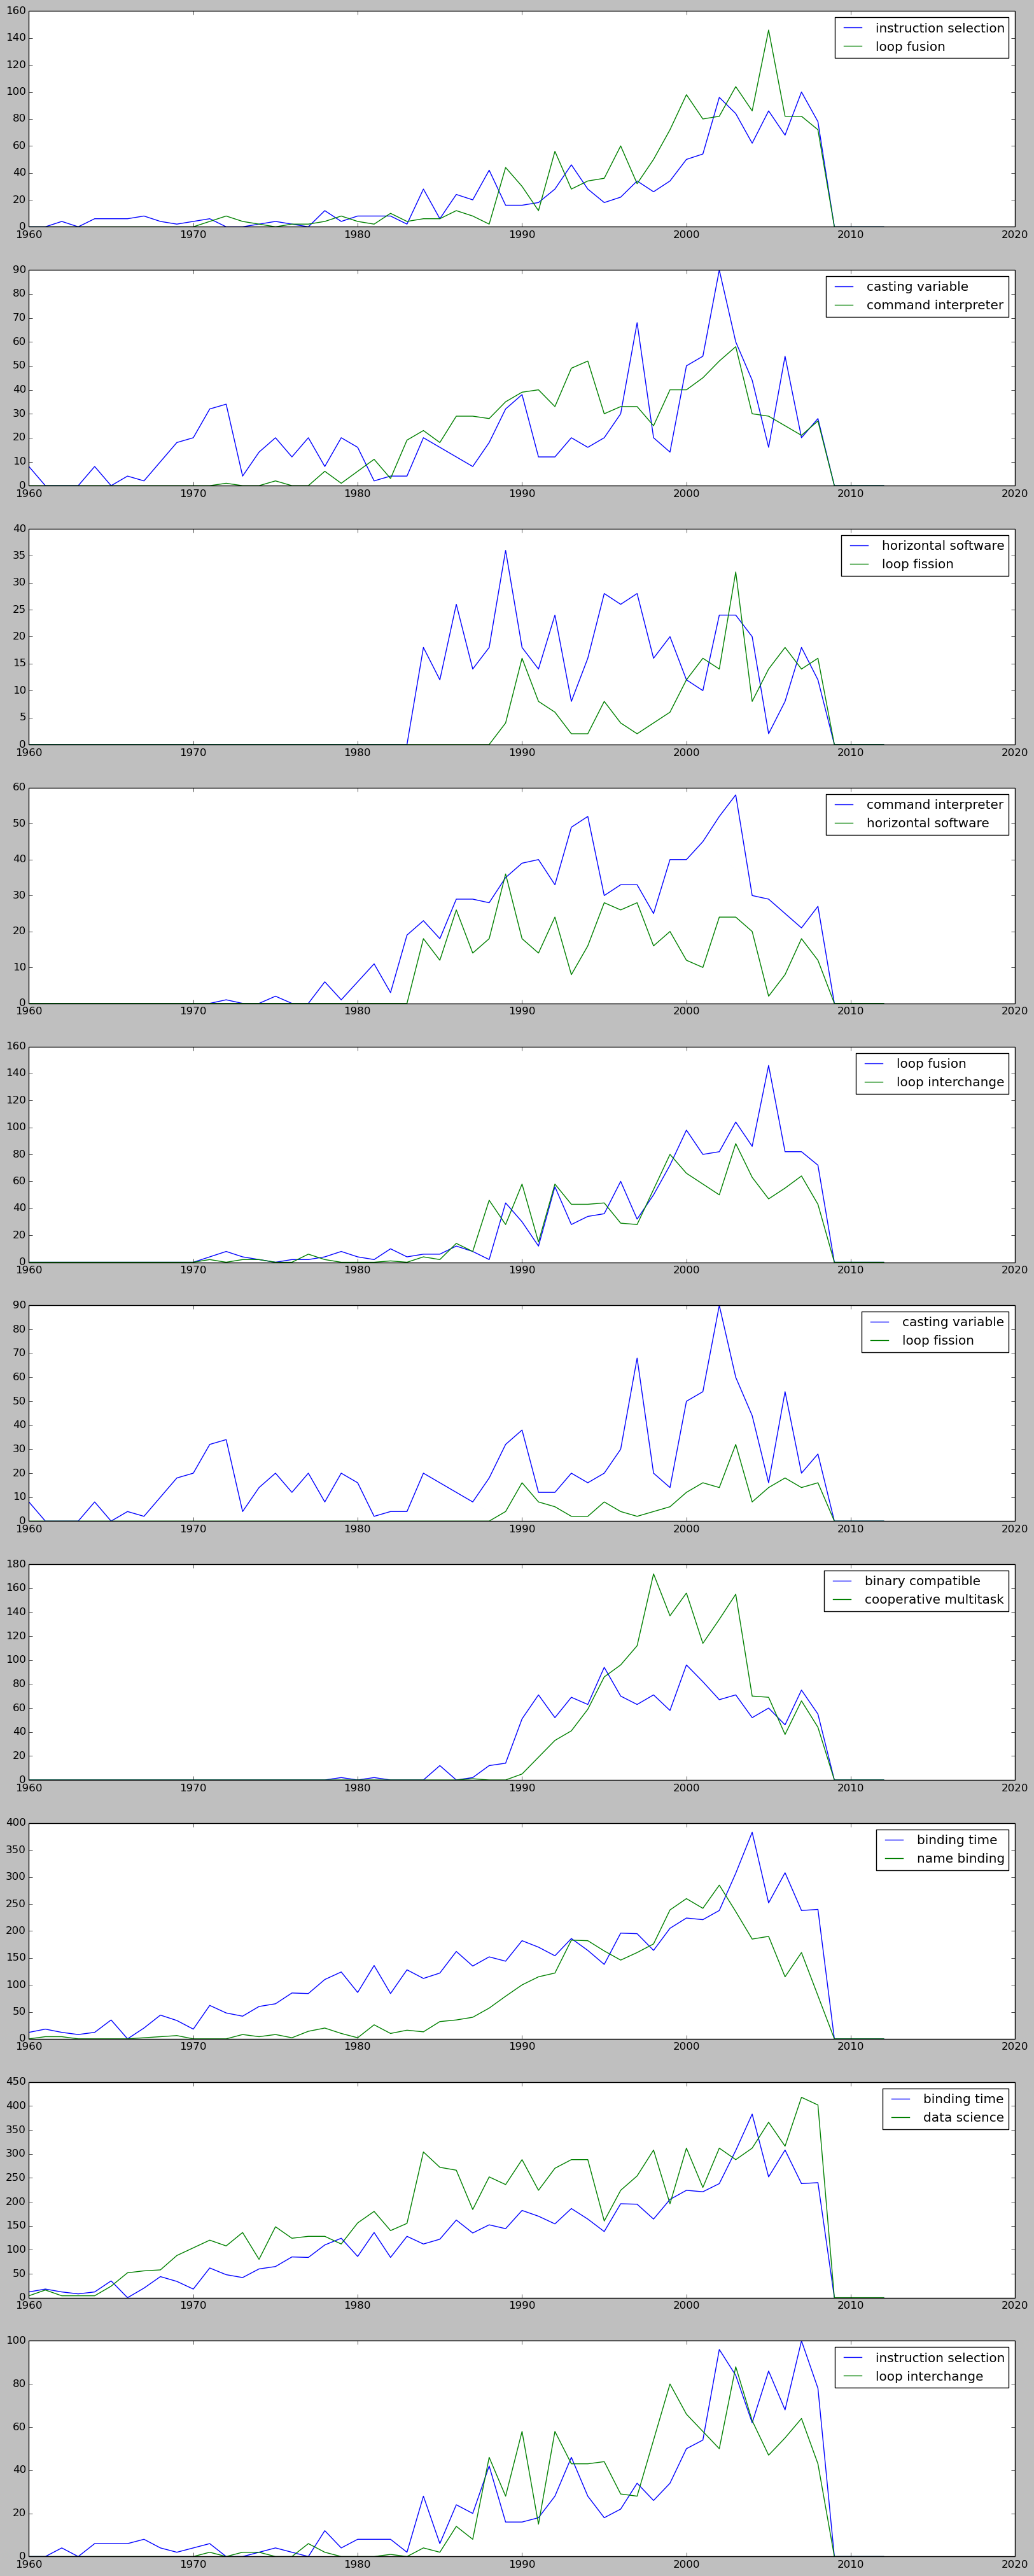

In [117]:
start = 1960
end = 2013
years = range(start, end)

num_plots = 10
fig = plt.figure(figsize=(20, num_plots*5))

for i in range(num_plots):
    t1, t2 = l1_selected[i]  
    #t1, t2 = l1_top[i]
    trend1 = get_vol_count(volTrendRDD, t1, start, end)
    trend2 = get_vol_count(volTrendRDD, t2, start, end)
    
    ax = plt.subplot(num_plots, 1, i)
    line1, = plt.plot(years, trend1, label=t1)
    line2, = plt.plot(years, trend2, label=t2)
    plt.legend([line1, line2], [t1, t2])
    


#### L2-Distance

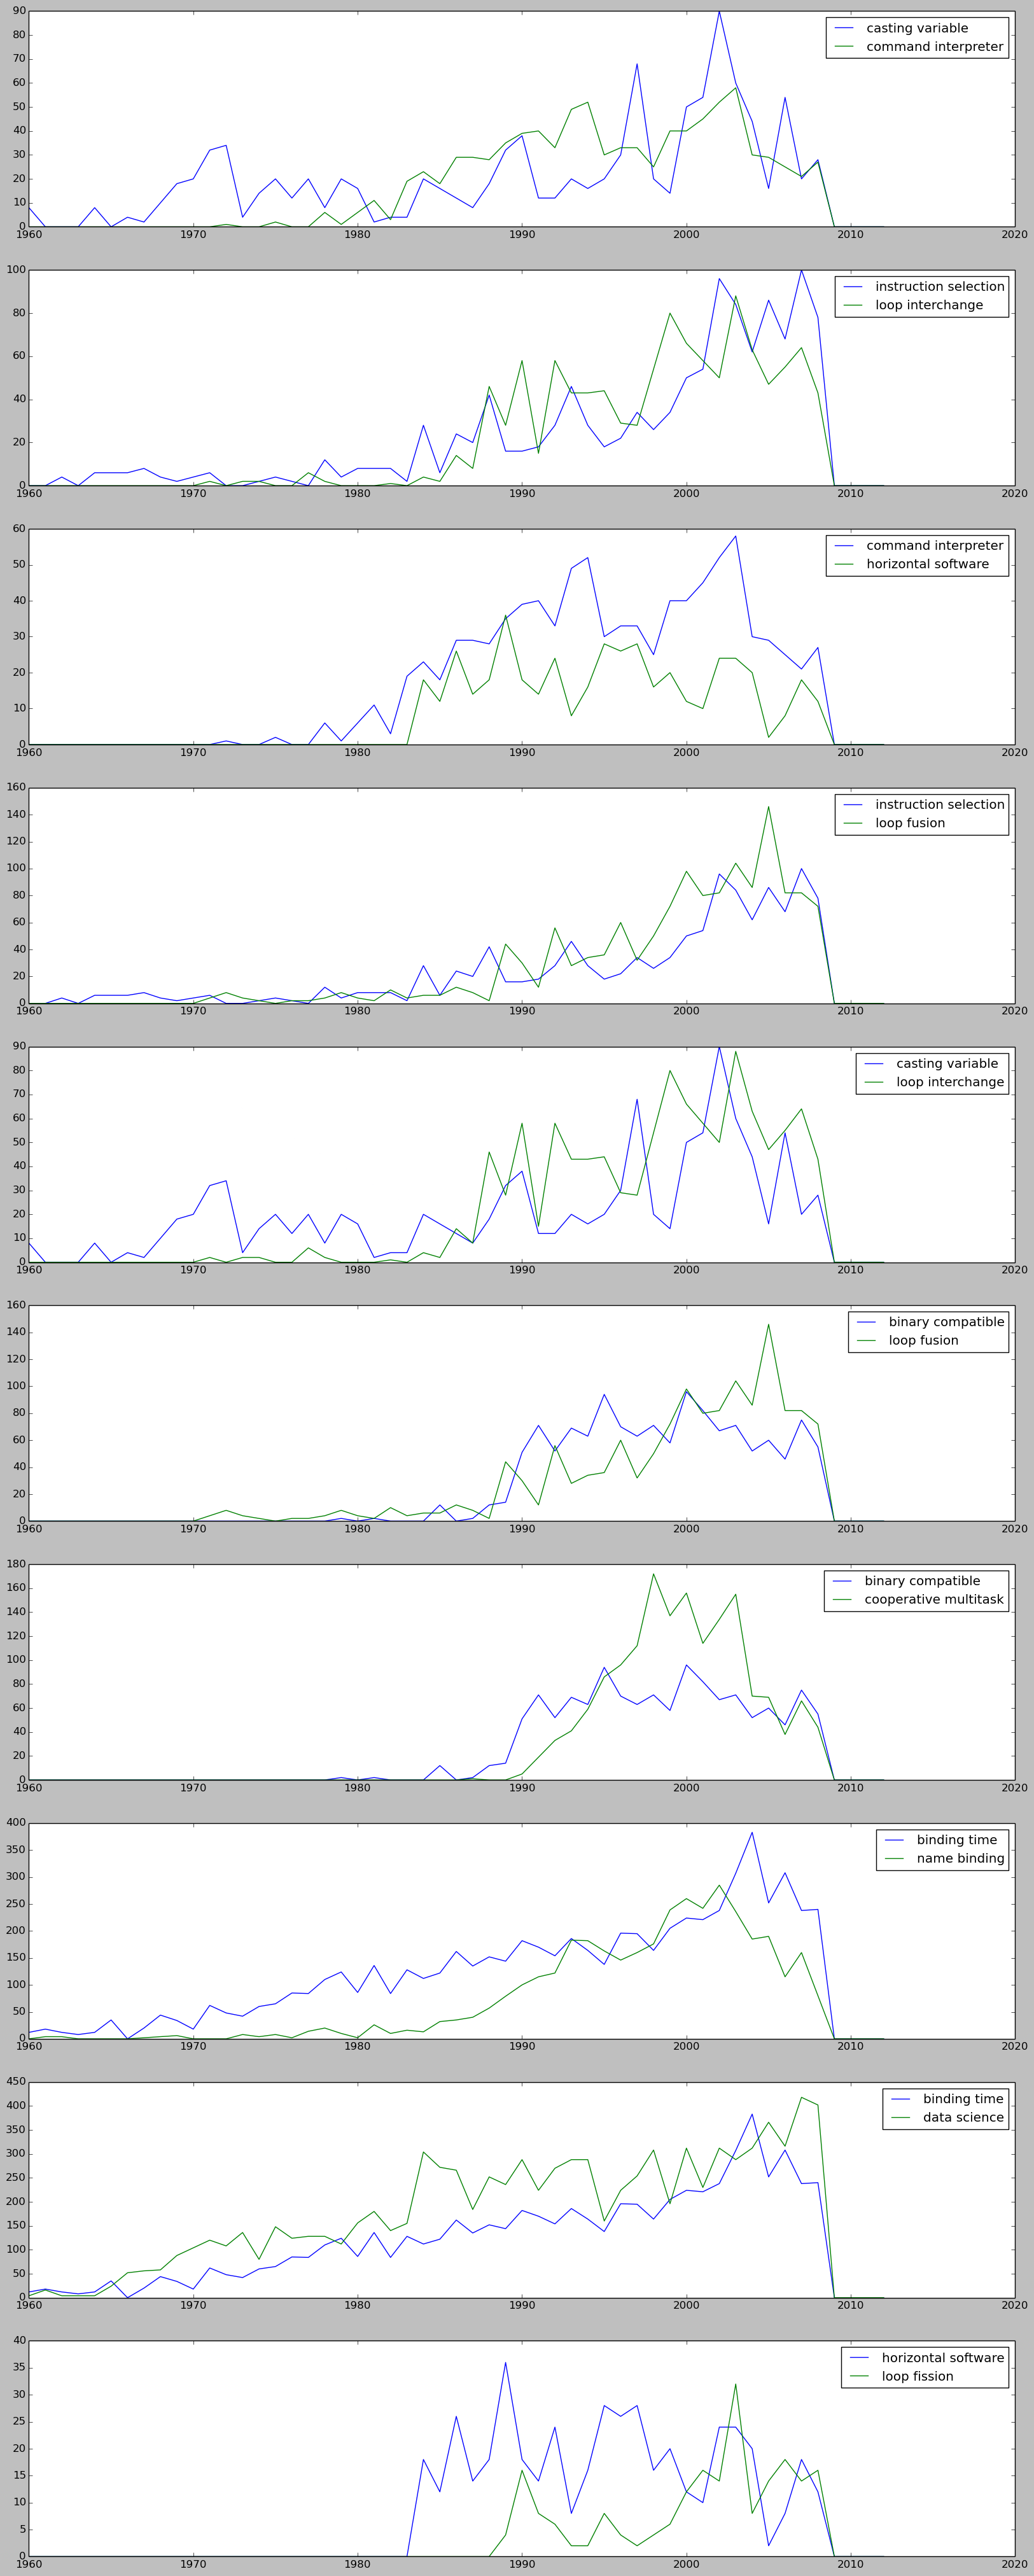

In [118]:
start = 1960
end = 2013
years = range(start, end)

num_plots = 10
fig = plt.figure(figsize=(20, num_plots*5))

for i in range(num_plots):
    t1, t2 = l2_selected[i]  
    #t1, t2 = l2_top[i]
    trend1 = get_vol_count(volTrendRDD, t1, start, end)
    trend2 = get_vol_count(volTrendRDD, t2, start, end)
    
    plt.subplot(num_plots, 1, i)
    line1, = plt.plot(years, trend1, label=t1)
    line2, = plt.plot(years, trend2, label=t2)
    plt.legend([line1, line2], [t1, t2]) 

#### Cosine Similarity

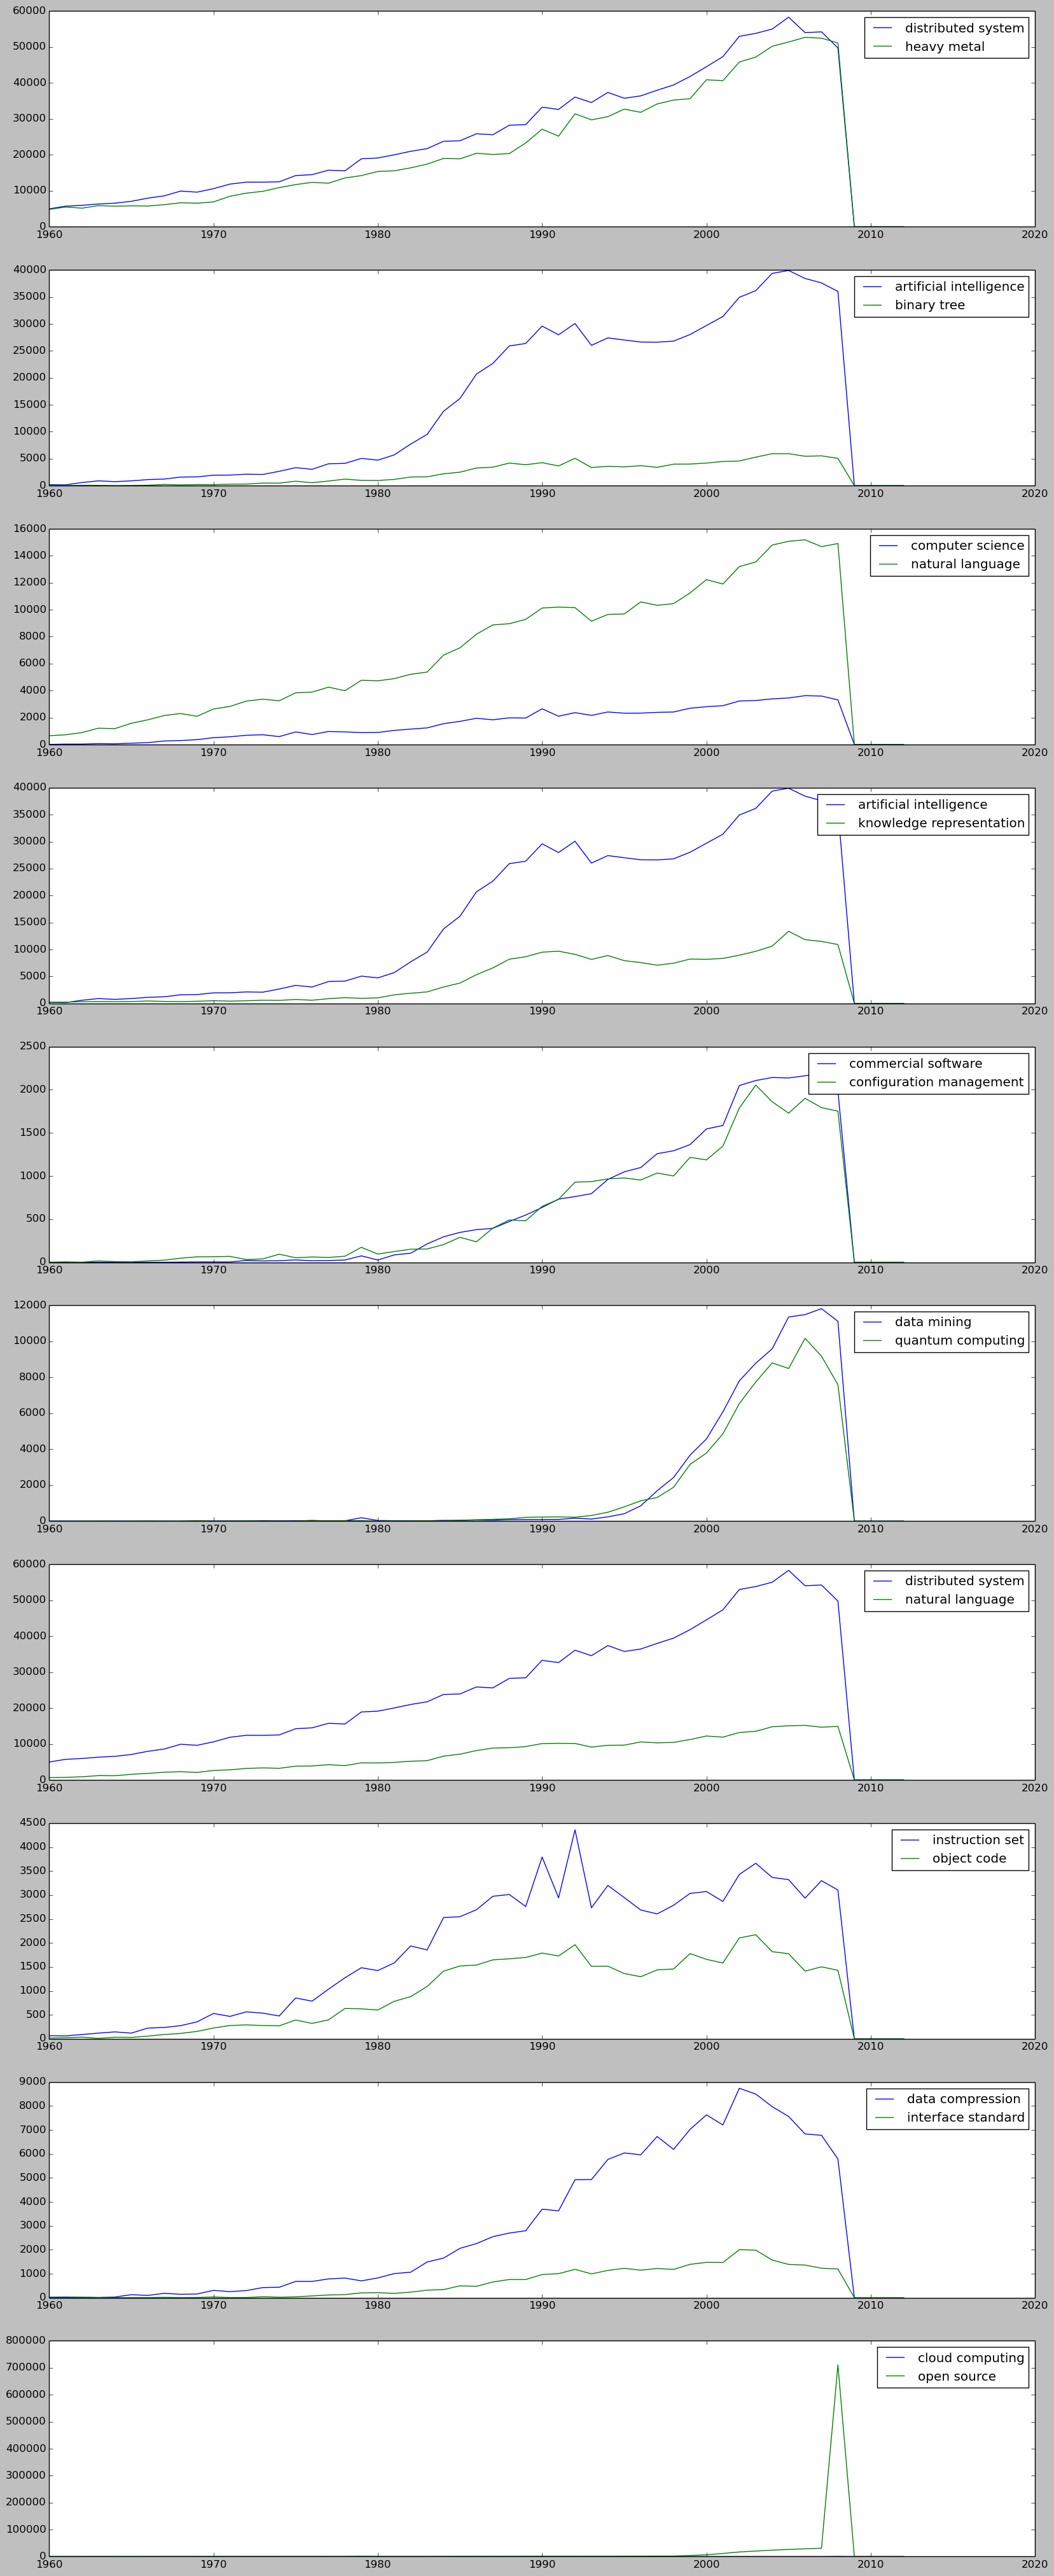

In [119]:
start = 1960
end = 2013
years = range(start, end)

num_plots = 10
fig = plt.figure(figsize=(20, num_plots*5))

for i in range(num_plots):
    t1, t2 = cossim_selected[i]
    #t1, t2 = cossim_top[i]
    trend1 = get_vol_count(volTrendRDD, t1, start, end)
    trend2 = get_vol_count(volTrendRDD, t2, start, end)
    
    plt.subplot(num_plots, 1, i)
    line1, = plt.plot(years, trend1, label=t1)
    line2, = plt.plot(years, trend2, label=t2)
    plt.legend([line1, line2], [t1, t2]) 

## Page Frequency over Years

In [78]:
def page_freq(dataRDD):
    topic_yr_to_nvol = (dataRDD
                        .map(lambda x: ((x[0], x[2]), x[3]))
                        .reduceByKey(add)
                       )
    return topic_yr_to_nvol

pageFreqRDD = page_freq(dataRDD)
print pageFreqRDD.take(5)

[((u'amplitude modulation', 1996), 12237), ((u'distributed system', 1918), 5622), ((u'information theory', 1930), 16), ((u'college education', 1826), 24), ((u'nuclear weapon', 1994), 218885)]


In [79]:
def page_freq_trend(dataRDD):
    topic_to_yr_page = (dataRDD
                       .map(lambda x: (x[0][0], {x[0][1]: x[1]}))
                       .reduceByKey(merge_dict)                       
                      )
    return topic_to_yr_page

pageTrendRDD = page_freq_trend(pageFreqRDD)
print pageTrendRDD.take(1)

[(u'communist party', {1777: 4, 1817: 4, 1827: 24, 1838: 224, 1839: 8, 1846: 8, 1848: 4, 1849: 12, 1851: 8, 1854: 80, 1863: 12, 1865: 4, 1868: 4, 1869: 4, 1870: 104, 1871: 32, 1872: 40, 1873: 8, 1874: 8, 1875: 28, 1876: 12, 1877: 32, 1878: 32, 1879: 32, 1880: 40, 1881: 48, 1882: 8, 1883: 56, 1884: 48, 1885: 28, 1886: 8, 1887: 16, 1888: 16, 1889: 4, 1890: 28, 1891: 100, 1892: 88, 1893: 220, 1894: 132, 1895: 56, 1896: 56, 1897: 12, 1898: 68, 1899: 100, 1900: 136, 1901: 152, 1902: 156, 1903: 136, 1904: 120, 1905: 72, 1906: 172, 1907: 248, 1908: 196, 1909: 148, 1910: 60, 1911: 152, 1912: 172, 1913: 96, 1914: 160, 1915: 244, 1916: 92, 1917: 1096, 1918: 516, 1919: 1428, 1920: 6688, 1921: 8752, 1922: 5740, 1923: 5364, 1924: 7668, 1925: 5198, 1926: 5536, 1927: 11994, 1928: 9644, 1929: 9710, 1930: 13420, 1931: 17444, 1932: 18696, 1933: 14988, 1934: 26790, 1935: 29794, 1936: 24317, 1937: 32270, 1938: 39683, 1939: 33584, 1940: 43774, 1941: 25522, 1942: 23766, 1943: 23396, 1944: 28764, 1945: 28055

In [80]:
all_pairs_page = pageTrendRDD.cartesian(pageTrendRDD)

#### L1-Distance
This part computes the L1 distance between each topic pairs, and lists out the pairs that have smaller distances.

In [81]:
dist_l1_page = pair_comparison(all_pairs_page, distance_l1)
dist_l1_page_list = dist_l1_page.collect()
dist_l1_page_list.sort(key=lambda x: x[1])

print '='*50
print 'Top 20 records'
print '='*50
l1_page_top = print_result(dist_l1_page_list, 20)

Top 20 records
casting variable		loop fission		19.0714285714
casting variable		command interpreter		21.0877192982
casting variable		horizontal software		23.6607142857
command interpreter		horizontal software		26.7714285714
command interpreter		loop fission		28.3428571429
binary compatible		casting variable		36.9821428571
instruction selection		loop interchange		40.0754716981
binary compatible		loop interchange		42.1764705882
binary compatible		command interpreter		44.4285714286
horizontal software		loop fission		44.76
binary compatible		instruction selection		44.96
casting variable		instruction selection		45.0806451613
command interpreter		instruction selection		46.4423076923
casting variable		loop interchange		49.350877193
horizontal software		instruction selection		52.56
instruction selection		loop fusion		53.1509433962
cooperative multitask		instruction selection		55.54
command interpreter		loop interchange		57.575
instruction selection		loop fission		58.86
binary compatible		horizo

In [111]:
print '='*50
print 'Selected 10 records'
print '='*50
l1_page_selected = select_result(dist_l1_page_list, 20)

Selected 10 records
casting variable		loop fission		19.0714285714
casting variable		command interpreter		21.0877192982
command interpreter		horizontal software		26.7714285714
instruction selection		loop interchange		40.0754716981
binary compatible		loop interchange		42.1764705882
horizontal software		loop fission		44.76
binary compatible		instruction selection		44.96
cooperative multitask		name binding		78.2156862745
binding time		name binding		83.640776699
cooperative multitask		loop fusion		83.8378378378
binding time		data science		87.7019230769
data science		internal command		126.408333333
biochemical weapon		closed source		126.606060606
amber alert		closed source		136.646464646
biochemical weapon		loop fusion		140.5
internal command		object pool		187.991452991
homogeneous system		interface standard		304.431137725
commercial software		interface standard		363.072727273
homogeneous system		object database		390.335329341
amber alert		cloud computing		428.527777778


#### L2-Distance
This part computes the L2 distance between each topic pairs, and lists out the pairs that have smaller distances.

In [83]:
dist_l2_page = pair_comparison(all_pairs_page, distance_l2)
dist_l2_page_list = dist_l2_page.collect()
dist_l2_page_list.sort(key=lambda x: x[1])

print '='*50
print 'Top 20 records'
print '='*50
l2_page_top = print_result(dist_l2_page_list, 20)

Top 20 records
casting variable		command interpreter		28.2277703254
casting variable		loop fission		29.1492464985
command interpreter		loop fission		36.0126961739
casting variable		horizontal software		36.6764326821
command interpreter		horizontal software		39.6113259417
binary compatible		casting variable		56.326376719
horizontal software		loop fission		58.7309117927
binary compatible		command interpreter		62.3398519637
instruction selection		loop interchange		70.6615638362
binary compatible		horizontal software		71.4350261634
binary compatible		loop interchange		73.9606413614
casting variable		loop interchange		80.4479781783
binary compatible		instruction selection		85.6579243269
command interpreter		loop interchange		90.4421085557
casting variable		instruction selection		90.7176584155
binary compatible		loop fission		90.9032452666
command interpreter		instruction selection		98.5675285898
cooperative multitask		instruction selection		99.9494872423
horizontal software		instruction sel

In [112]:
print '='*50
print 'Selected 10 records'
print '='*50
l2_page_selected = select_result(dist_l2_page_list, 20)

Selected 10 records
casting variable		command interpreter		28.2277703254
casting variable		loop fission		29.1492464985
command interpreter		loop fission		36.0126961739
instruction selection		loop interchange		70.6615638362
binary compatible		horizontal software		71.4350261634
binary compatible		loop interchange		73.9606413614
cooperative multitask		instruction selection		99.9494872423
cooperative multitask		name binding		125.438446744
loop fusion		name binding		142.768912107
binding time		data science		162.875217693
horizontal software		loop fusion		183.11693207
binding time		internal command		247.203524922
data science		internal command		285.125513298
biochemical weapon		closed source		332.345262848
closed source		object pool		344.459641242
homogeneous system		interface standard		455.847949752
homogeneous system		object database		639.171628952
biochemical weapon		cloud computing		653.538437555
interface standard		object database		706.163465495
cloud computing		object pool		966.4363518

#### Cosine Similarity
This part computes the cosine similarity between each topic pairs, and lists out the pairs that have highest similarities.

In [93]:
cossim_page = pair_comparison(all_pairs_page, cosine_similarity)
cossim_page_list = cossim_page.collect()
cossim_page_list.sort(key=lambda x: x[1], reverse=True)

print '='*50
print 'Top 20 records'
print '='*50
cossim_page_top = print_result(cossim_page_list, 20)

Top 20 records
distributed system		heavy metal		0.993903087223
barack obama		cloud computing		0.993793301756
feminist movement		heavy metal		0.989027225592
electronic book		information technology		0.985454903055
artificial intelligence		binary tree		0.985362375983
distributed system		question answering		0.984858623149
artificial intelligence		knowledge representation		0.984750534215
distributed system		feminist movement		0.984705239252
heavy metal		question answering		0.983297848315
natural language		nuclear weapon		0.983230928174
barack obama		open source		0.982619840727
integrated circuit		natural language		0.981484019052
data compression		interface standard		0.981478965353
database server		legacy system		0.981362766058
cloud computing		open source		0.981160772566
distributed system		natural language		0.980797693135
artificial intelligence		computer graphic		0.97964246227
information technology		machine learning		0.978708665654
integrated circuit		object code		0.978625658487
artifici

In [113]:
print '='*50
print 'Selected 10 records'
print '='*50
cossim_page_selected = select_result(cossim_page_list, 20)

Selected 10 records
distributed system		heavy metal		0.993903087223
barack obama		cloud computing		0.993793301756
feminist movement		heavy metal		0.989027225592
electronic book		information technology		0.985454903055
artificial intelligence		binary tree		0.985362375983
distributed system		question answering		0.984858623149
artificial intelligence		knowledge representation		0.984750534215
natural language		nuclear weapon		0.983230928174
barack obama		open source		0.982619840727
integrated circuit		natural language		0.981484019052
data compression		interface standard		0.981478965353
database server		legacy system		0.981362766058
cloud computing		open source		0.981160772566
information technology		machine learning		0.978708665654
integrated circuit		object code		0.978625658487
college education		information theory		0.978056746997
electronic book		machine learning		0.976925757713
amplitude modulation		college education		0.976877194935
database server		object model		0.971447741707
computer 

## Visualization

#### L1-Distance

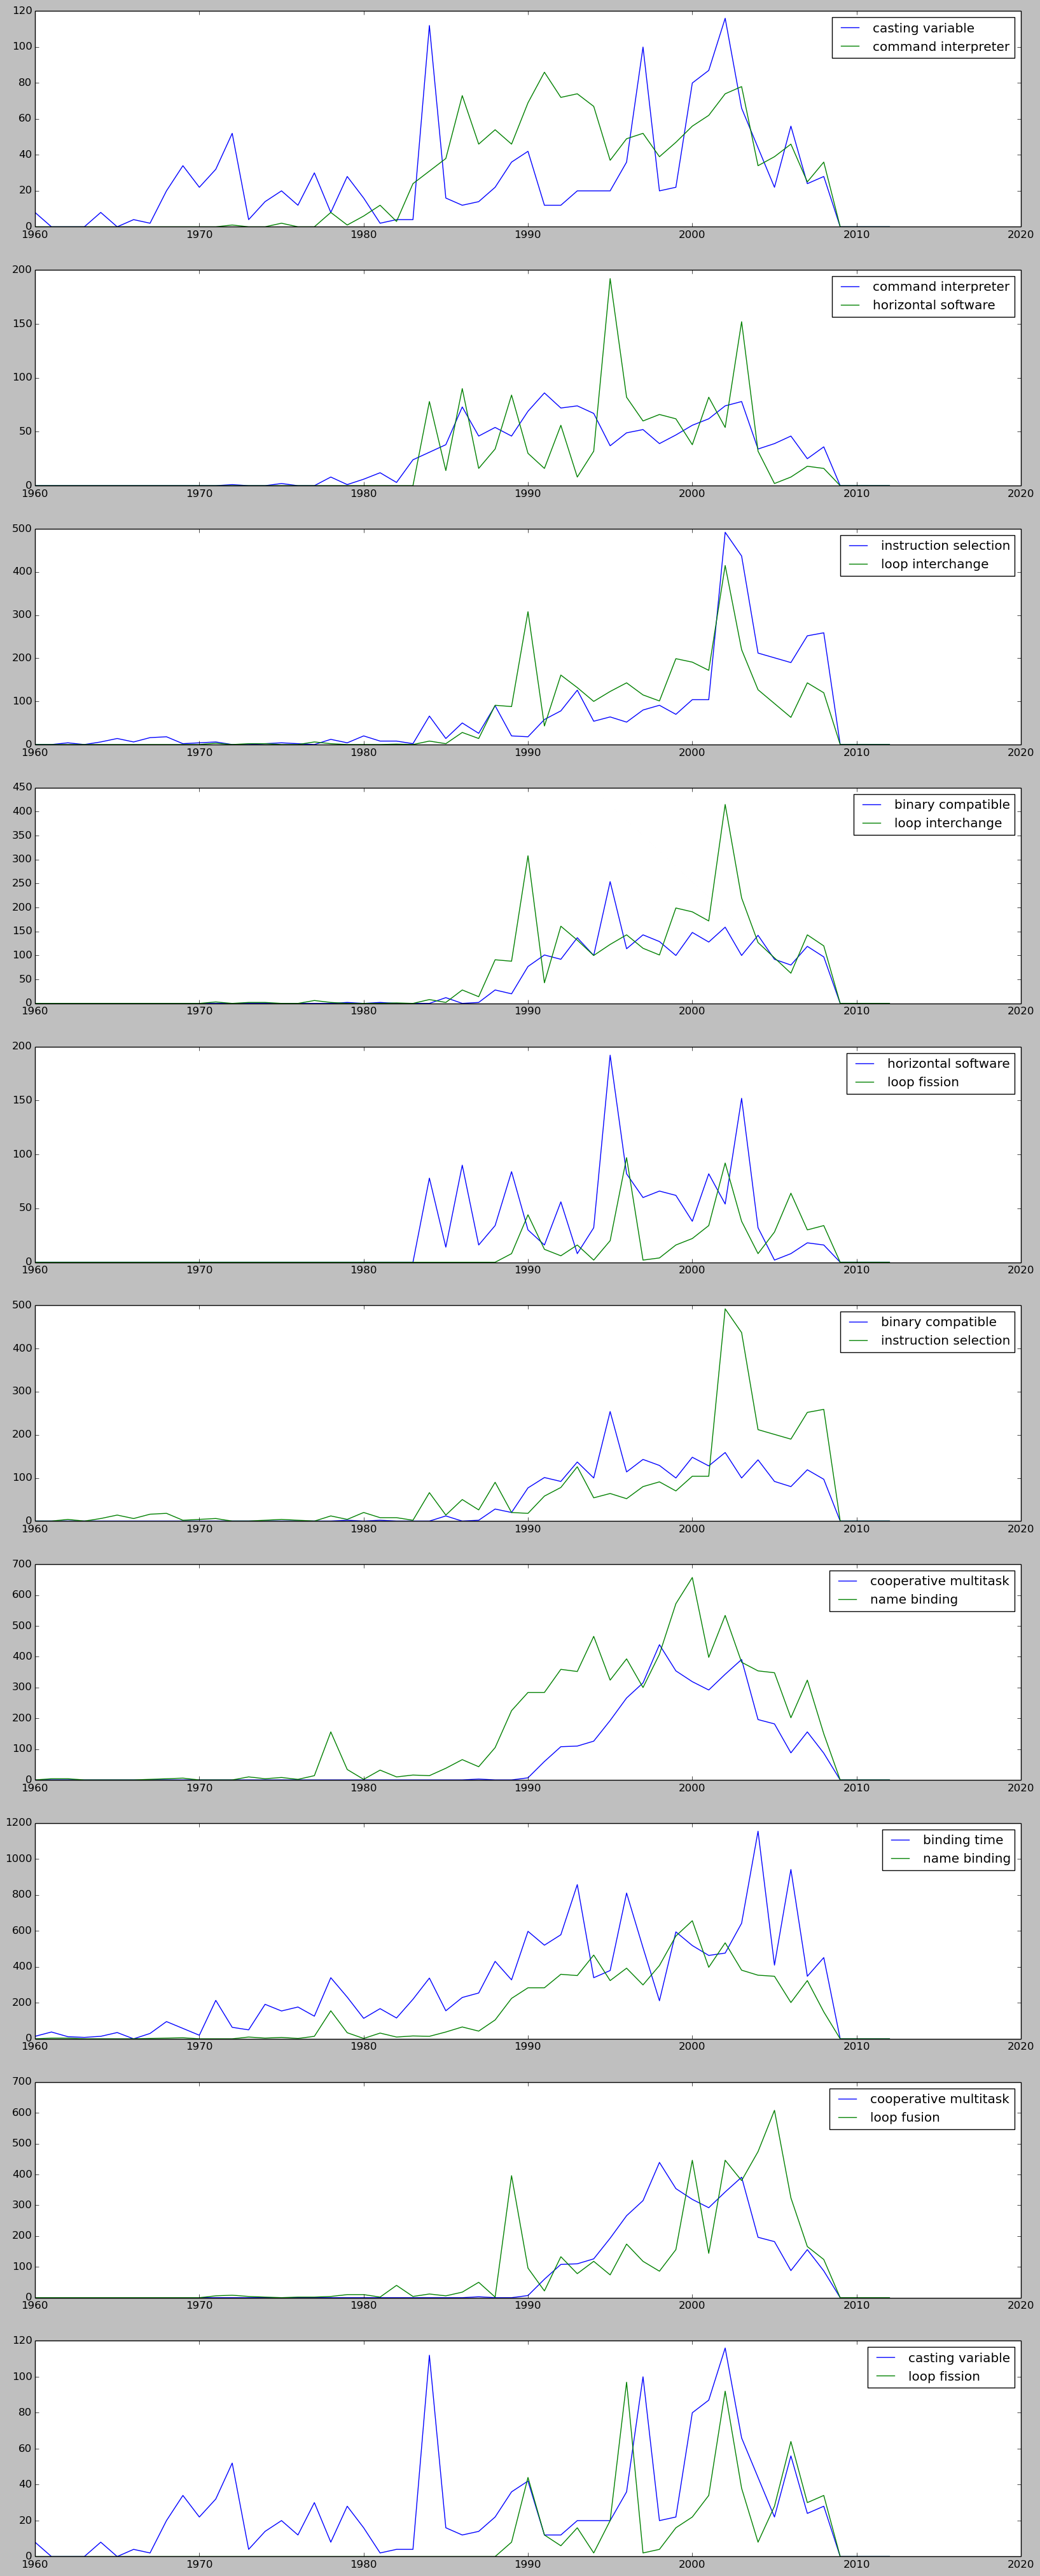

In [120]:
start = 1960
end = 2013
years = range(start, end)

num_plots = 10
fig = plt.figure(figsize=(20, num_plots*5))

for i in range(num_plots):
    t1, t2 = l1_page_selected[i]  
    #t1, t2 = l1_page_top[i]
    trend1 = get_vol_count(pageTrendRDD, t1, start, end)
    trend2 = get_vol_count(pageTrendRDD, t2, start, end)
    
    plt.subplot(num_plots, 1, i)
    line1, = plt.plot(years, trend1, label=t1)
    line2, = plt.plot(years, trend2, label=t2)
    plt.legend([line1, line2], [t1, t2])

#### L2-Distance

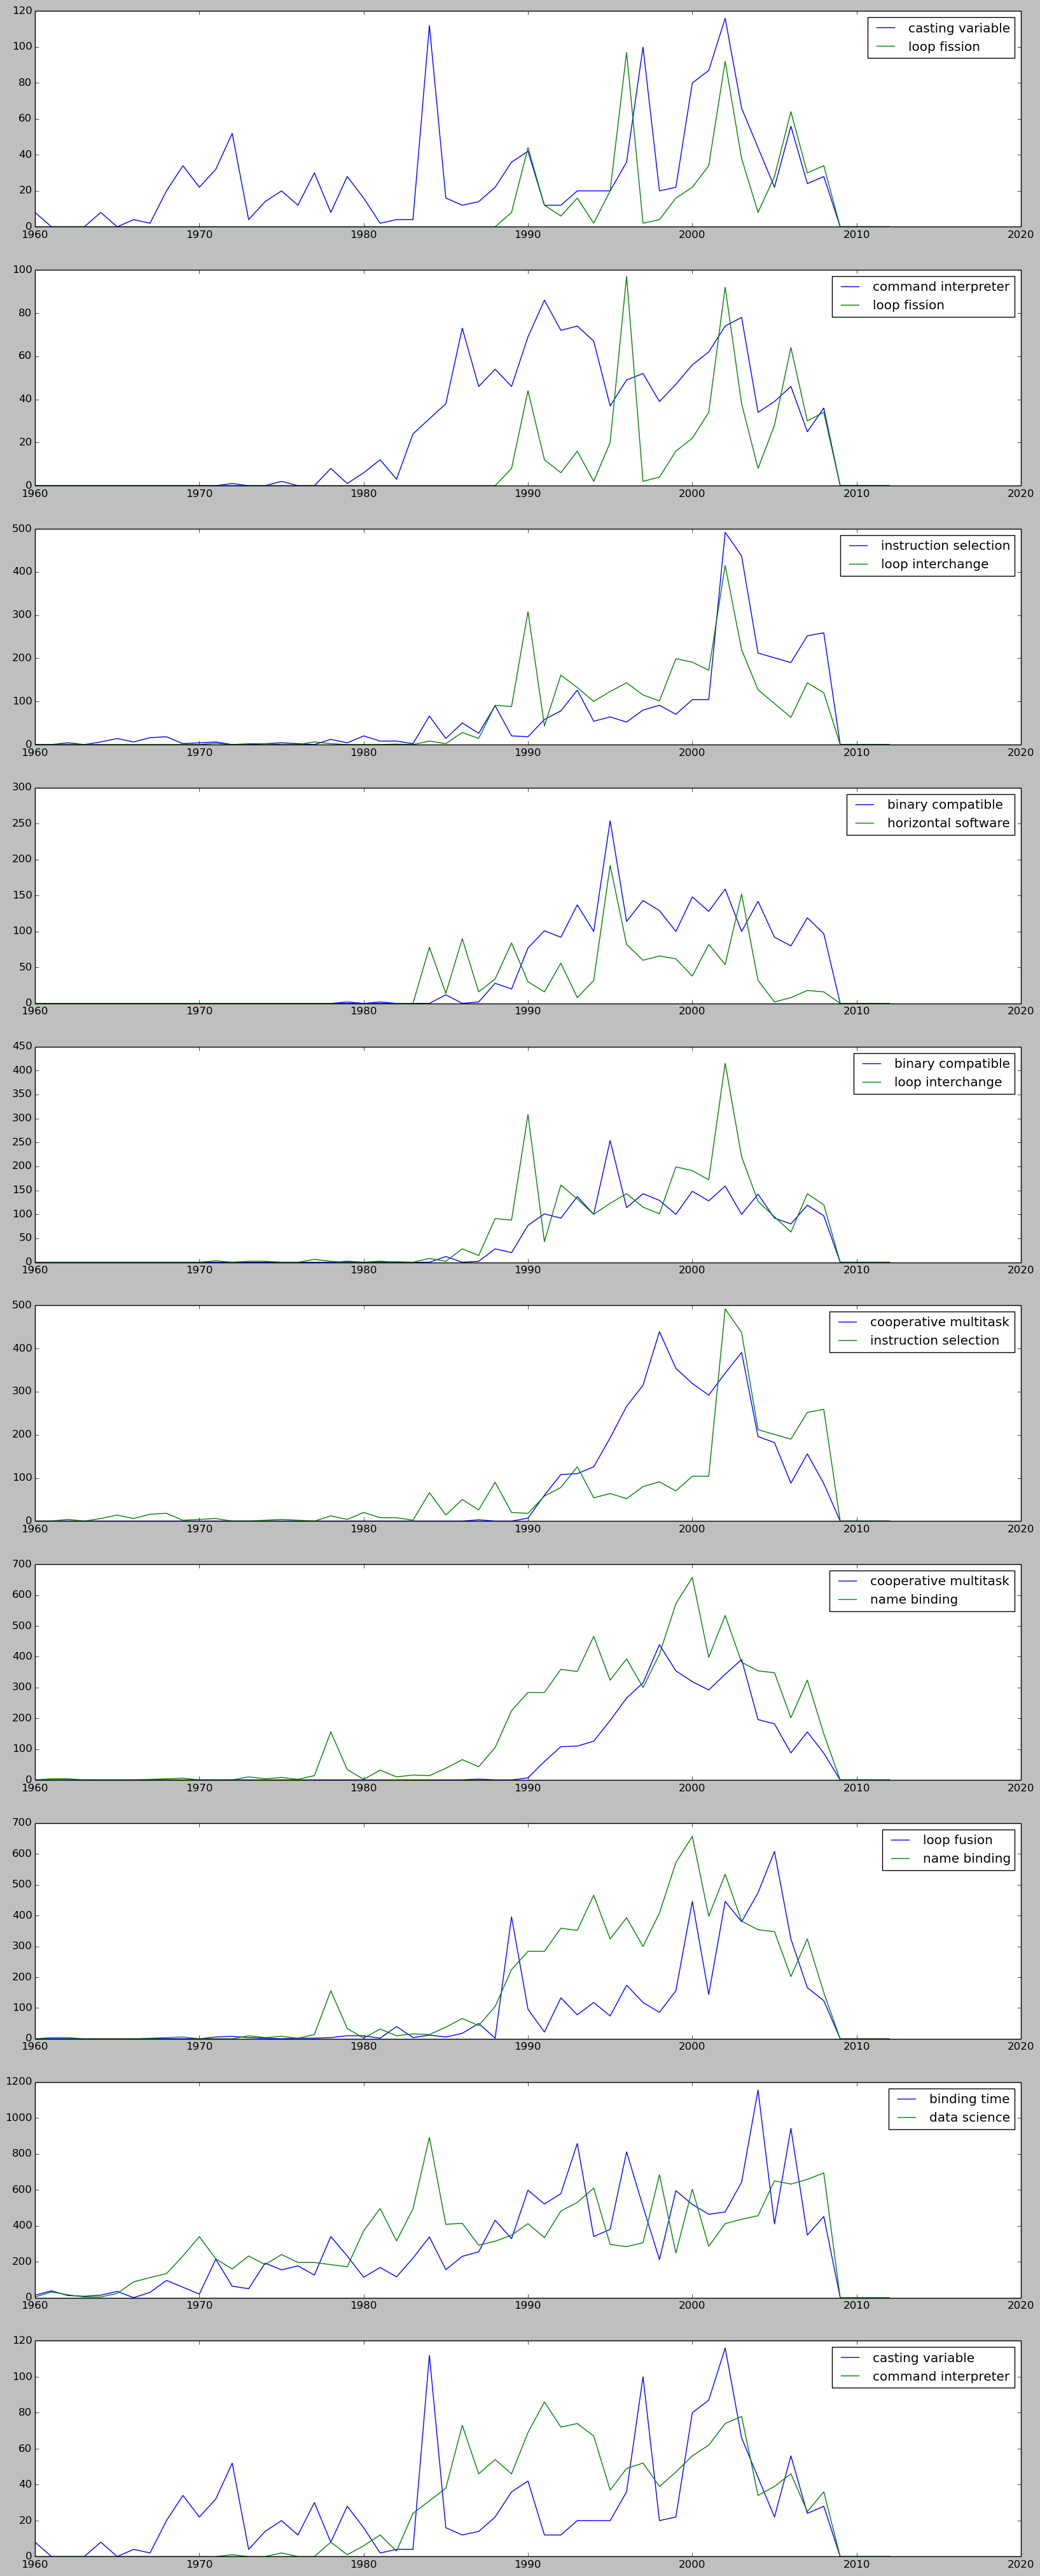

In [121]:
start = 1960
end = 2013
years = range(start, end)

num_plots = 10
fig = plt.figure(figsize=(20, num_plots*5))

for i in range(num_plots):
    t1, t2 = l2_page_selected[i]  
    #t1, t2 = l2_page_top[i]
    trend1 = get_vol_count(pageTrendRDD, t1, start, end)
    trend2 = get_vol_count(pageTrendRDD, t2, start, end)
    
    plt.subplot(num_plots, 1, i)
    line1, = plt.plot(years, trend1, label=t1)
    line2, = plt.plot(years, trend2, label=t2)
    plt.legend([line1, line2], [t1, t2])

#### Cosine Similarity

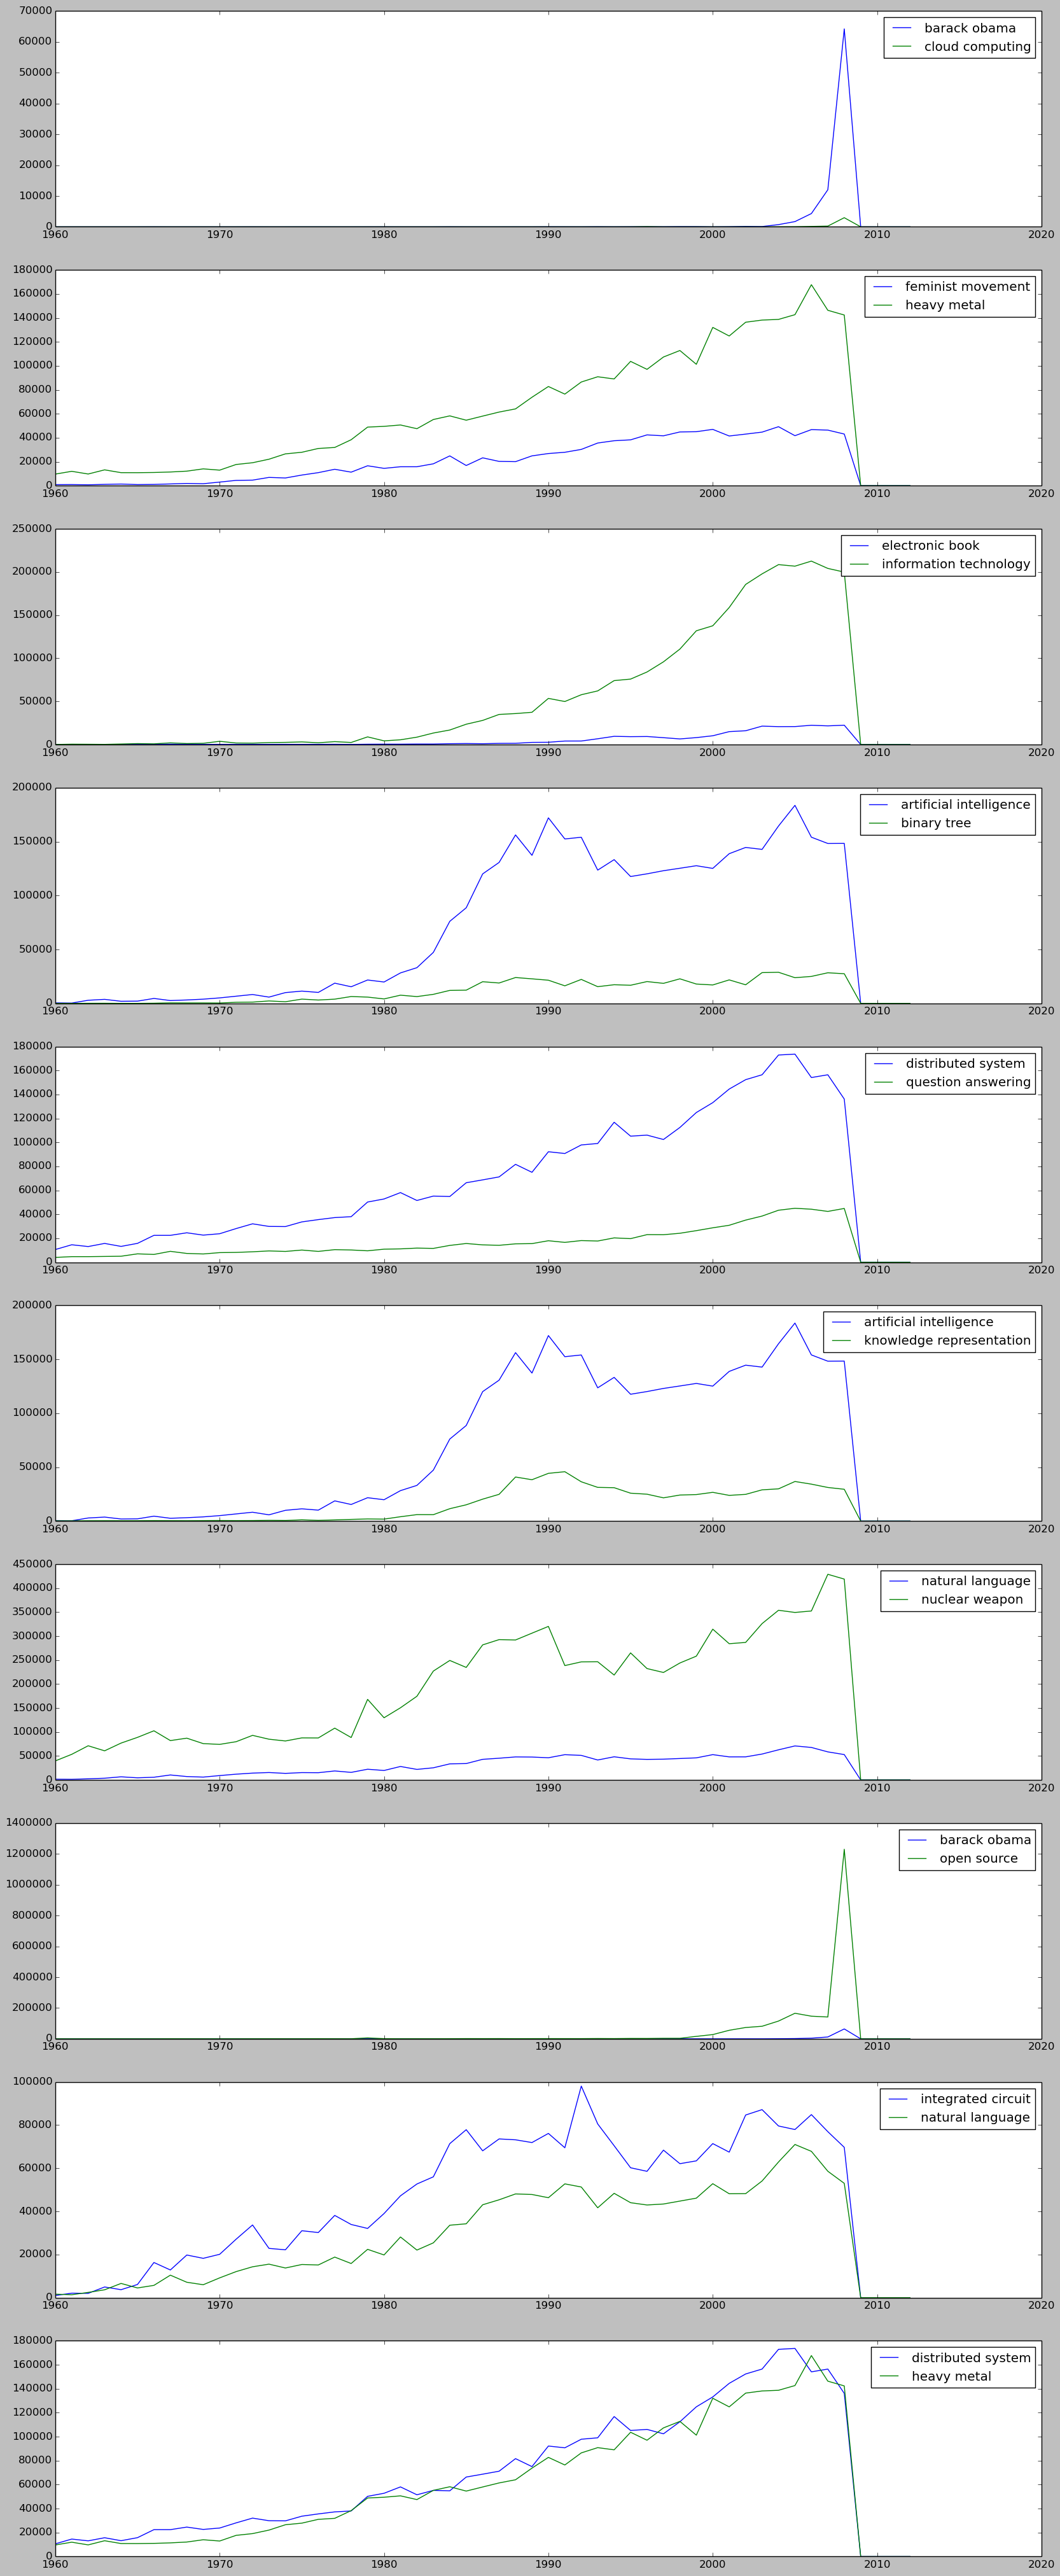

In [122]:
start = 1960
end = 2013
years = range(start, end)

num_plots = 10
fig = plt.figure(figsize=(20, num_plots*5))

for i in range(num_plots):
    t1, t2 = cossim_page_selected[i]  
    #t1, t2 = cossim_page_top[i]
    trend1 = get_vol_count(pageTrendRDD, t1, start, end)
    trend2 = get_vol_count(pageTrendRDD, t2, start, end)
    
    plt.subplot(num_plots, 1, i)
    line1, = plt.plot(years, trend1, label=t1)
    line2, = plt.plot(years, trend2, label=t2)
    plt.legend([line1, line2], [t1, t2])